# Flower classification model training notebook
In this notebook we finetune a model to classify flowers

In [1]:
import os
from os.path import join as opj
import shutil
from collections import Counter
from datetime import datetime

In [2]:
import kagglehub
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from tqdm.autonotebook import tqdm
import splitfolders
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from model_utils import freeze_backbone, modify_clsf_head
from train import train_model, plot_training_results, get_test_predicts, get_test_metrics

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
RANDOM_SEED = 777
BATCH_SIZE = 64

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic=True

# 1. Download and prepare Data

## 1.1 Download dataset
Download dataset from kaggle and visualise some samples

In [4]:
def visualise_samples(dataset, samples_per_class=5, title="Dataset samples"):
    fig, axes = plt.subplots(samples_per_class, len(dataset.classes), figsize=(15, samples_per_class * 2))
    fig.suptitle(title, fontsize=15)
    axes = axes
    for i in range(0, len(dataset.classes)):
        idxs = np.where(np.array(dataset.targets) == i)[0]
        for j, idx in enumerate(idxs[:samples_per_class]):
            if j == 0:
                axes[j][i].set_title(idx_to_class[i], fontsize=10)
            axes[j][i].imshow(dataset[idx][0])
            axes[j][i].axis('off')
    plt.show()

In [5]:
base_path = kagglehub.dataset_download('alxmamaev/flowers-recognition')
dataset_dir = opj(base_path, "flowers")
dataset = ImageFolder(dataset_dir)

idx_to_class = {v:k for k, v in dataset.class_to_idx.items()}
targets_names = [idx_to_class[v] for v in dataset.targets]
targets = np.array(dataset.targets)
n_classes = len(dataset.classes)

Dataset summary:
 4317 samples
 * daisy: 764 samples (17%)
 * dandelion: 1052 samples (24%)
 * rose: 784 samples (18%)
 * sunflower: 733 samples (16%)
 * tulip: 984 samples (22%)


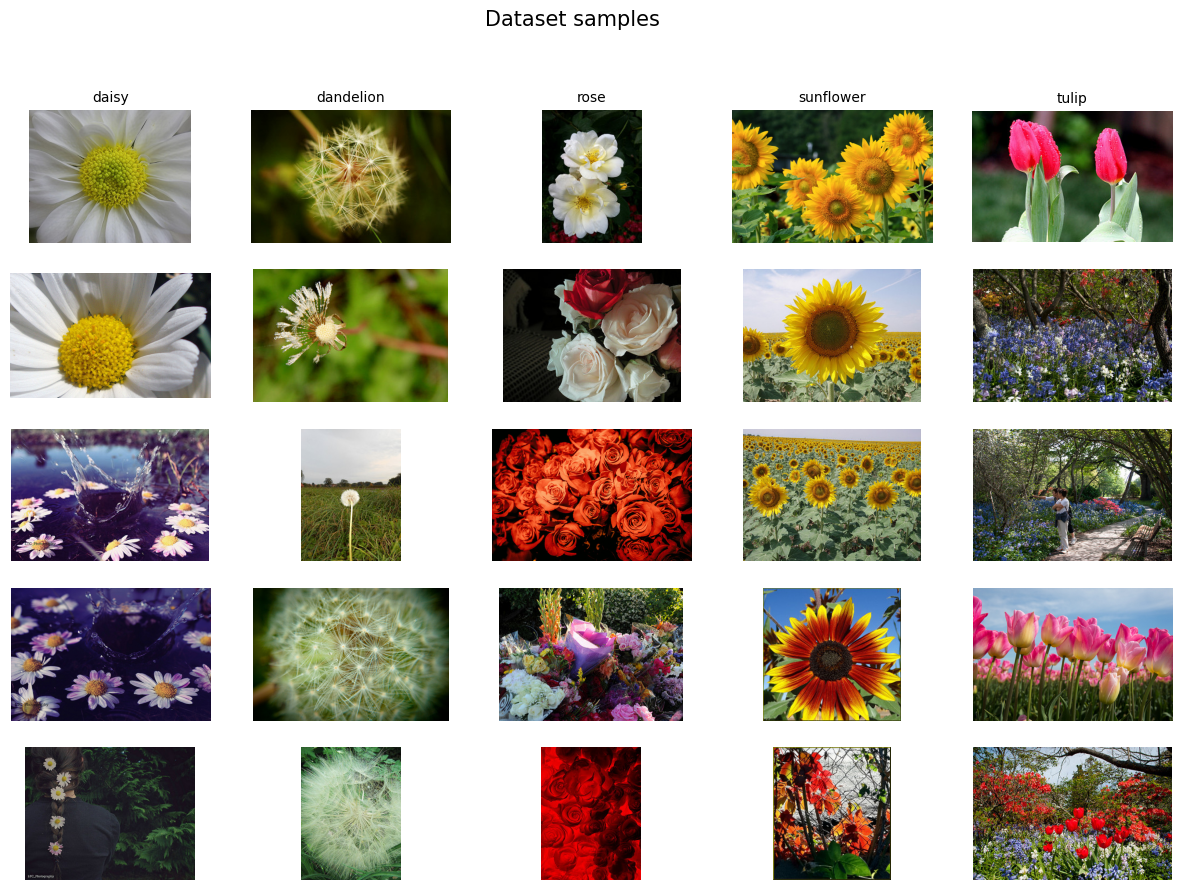

In [6]:
print(f"Dataset summary:\n {len(dataset)} samples")
for k, v in Counter(dataset.targets).items():
    print (f" * {idx_to_class[k]}: {v} samples ({int(100 * v / len(dataset))}%)")
    
visualise_samples(dataset)

## 1.2 Train/test/val split

In [7]:
splitted_path = './data/flowers'
splitfolders.ratio(
    input=dataset_dir, output=splitted_path, seed=RANDOM_SEED, ratio=(0.7, 0.15, 0.15)
)

Copying files: 4317 files [00:03, 1405.69 files/s]


In [8]:
train_ds = ImageFolder(opj(splitted_path, "train"))
val_ds = ImageFolder(opj(splitted_path, "val"))
test_ds = ImageFolder(opj(splitted_path, "test"))
class_distribution = {}

for ds, split_name in zip((train_ds, val_ds, test_ds), ("train", "test", "val")):
    split_count = Counter(ds.targets)
    total_samples = sum(split_count.values())
    class_distribution[split_name] = {}
    for idx, count in split_count.items():
        class_distribution[split_name][idx_to_class[idx]] = \
            f"{count} ({int(100 * count / total_samples)}%)"
    class_distribution[split_name]["total"] = total_samples

class_distribution_df = pd.DataFrame(class_distribution).T
class_distribution_df

daisy  dandelion       rose  sunflower      tulip total
train  534 (17%)  736 (24%)  548 (18%)  513 (16%)  688 (22%)  3019
test   114 (17%)  157 (24%)  117 (18%)  109 (16%)  147 (22%)   644
val    116 (17%)  159 (24%)  119 (18%)  111 (16%)  149 (22%)   654

In [9]:
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=True
)

### 1.3 Add augmentations

In [10]:
augmentations = v2.Compose([
    v2.RandomRotation(degrees=(0, 15)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomResizedCrop(size=(224, 224), scale=(0.5, 1.0))
])

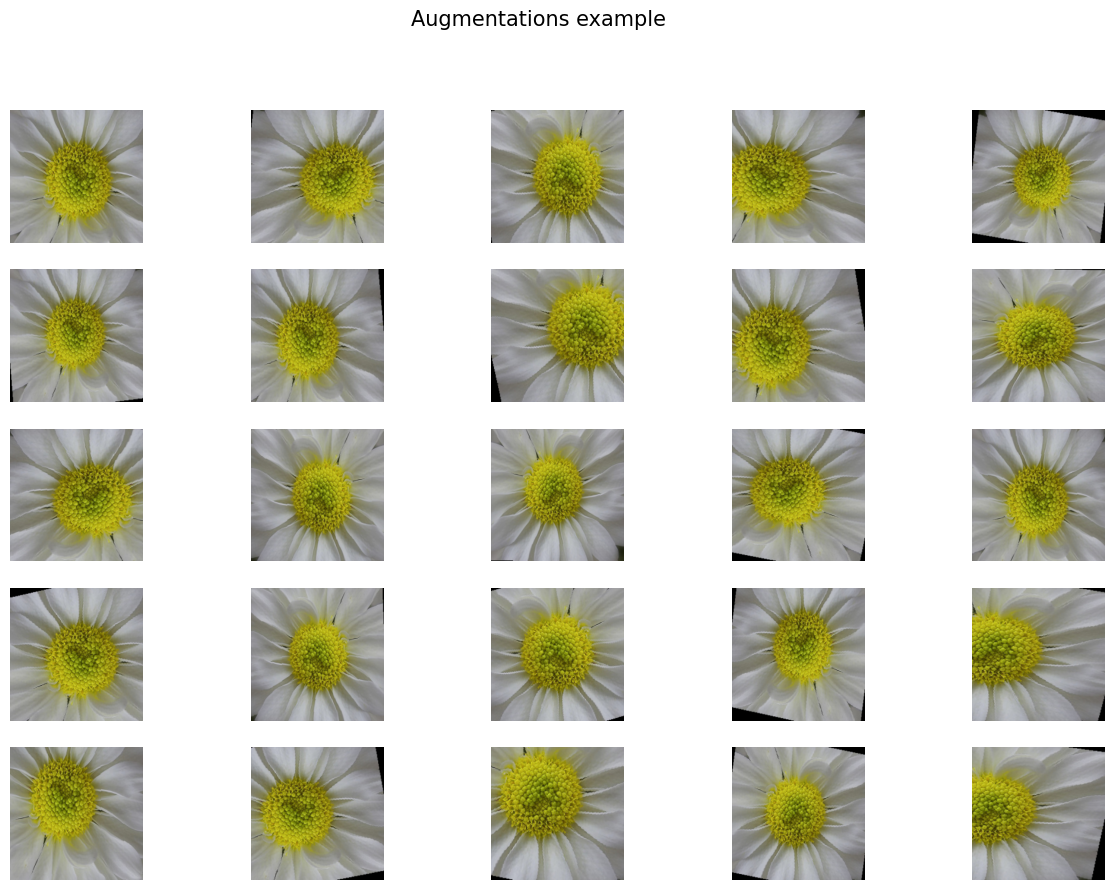

In [11]:
fig, axes = plt.subplots(5, 5, figsize=(15, 10))
fig.suptitle("Augmentations example", fontsize=15)
axes = axes.flatten()
dataset.transform = augmentations
for i in range(len(axes)):
    axes[i].imshow(dataset[0][0])
    axes[i].axis('off')

### 1.4 Create dataloaders

In [12]:
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False
)

# 2. Train models

In [13]:
from torchvision.models import regnet_x_800mf, RegNet_X_800MF_Weights
weights = RegNet_X_800MF_Weights.DEFAULT
regnetx_transforms = weights.transforms()
val_ds.transform = regnetx_transforms
test_ds.transform = regnetx_transforms
train_ds.transform = v2.Compose([augmentations, regnetx_transforms])

Epoch [1/10] -> Train Loss:0.7311, Train Acc:0.7198| Val Loss:0.4248, Val Acc:0.7445| Duration : 0:00:39.230062
Epoch [2/10] -> Train Loss:0.4483, Train Acc:0.8357| Val Loss:0.4020, Val Acc:0.8430| Duration : 0:00:40.167331
Epoch [3/10] -> Train Loss:0.3828, Train Acc:0.8619| Val Loss:0.4091, Val Acc:0.8654| Duration : 0:00:39.833742
Epoch [4/10] -> Train Loss:0.3556, Train Acc:0.8751| Val Loss:0.3949, Val Acc:0.8771| Duration : 0:00:39.921973
Epoch [5/10] -> Train Loss:0.3737, Train Acc:0.8662| Val Loss:0.3284, Val Acc:0.8684| Duration : 0:00:37.036252
Epoch [6/10] -> Train Loss:0.3358, Train Acc:0.8755| Val Loss:0.4216, Val Acc:0.8736| Duration : 0:00:38.737645
Epoch [7/10] -> Train Loss:0.3619, Train Acc:0.8715| Val Loss:0.3889, Val Acc:0.8736| Duration : 0:00:36.549358
Epoch [8/10] -> Train Loss:0.3257, Train Acc:0.8837| Val Loss:0.3860, Val Acc:0.8823| Duration : 0:00:36.780979
Epoch [9/10] -> Train Loss:0.3307, Train Acc:0.8798| Val Loss:0.3911, Val Acc:0.8793| Duration : 0:00:38

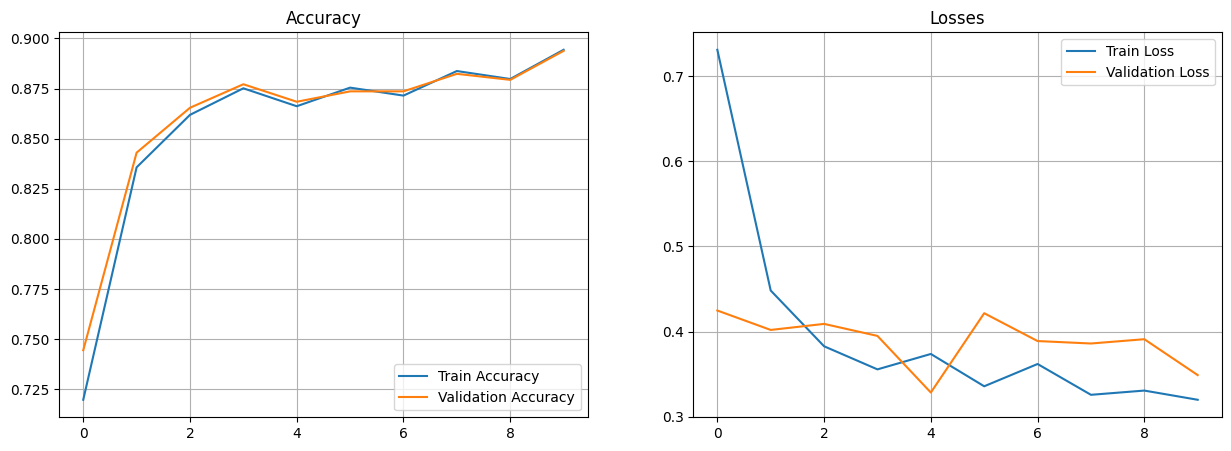

In [14]:
# Freezed backbone
regnetx_freeze = regnet_x_800mf(weights=weights)
regnetx_freeze = modify_clsf_head(regnetx_freeze, n_classes)
regnetx_freeze = freeze_backbone(regnetx_freeze)
regnetx_freeze.to(device)
regnetx_freeze, freeze_metrics = train_model(regnetx_freeze, train_loader, val_loader, epochs=10, device=device)
plot_training_results(freeze_metrics['train_accs'],
                    freeze_metrics['train_losses'],
                    freeze_metrics['val_accs'],
                    freeze_metrics['val_losses'])

Epoch [1/10] -> Train Loss:0.4901, Train Acc:0.8331| Val Loss:0.3365, Val Acc:0.8430| Duration : 0:01:26.173632
Epoch [2/10] -> Train Loss:0.2867, Train Acc:0.9039| Val Loss:0.3697, Val Acc:0.9031| Duration : 0:01:24.633142
Epoch [3/10] -> Train Loss:0.2469, Train Acc:0.9165| Val Loss:0.4246, Val Acc:0.9135| Duration : 0:01:24.880580
Epoch [4/10] -> Train Loss:0.2159, Train Acc:0.9304| Val Loss:0.7061, Val Acc:0.9121| Duration : 0:01:26.515336
Epoch [5/10] -> Train Loss:0.2388, Train Acc:0.9145| Val Loss:0.5236, Val Acc:0.9039| Duration : 0:01:26.730081
Epoch [6/10] -> Train Loss:0.1889, Train Acc:0.9394| Val Loss:0.4365, Val Acc:0.9287| Duration : 0:01:29.583303
Epoch [7/10] -> Train Loss:0.2182, Train Acc:0.9268| Val Loss:0.2652, Val Acc:0.9252| Duration : 0:01:30.732802
Epoch [8/10] -> Train Loss:0.1869, Train Acc:0.9357| Val Loss:0.3479, Val Acc:0.9320| Duration : 0:01:25.135305
Epoch [9/10] -> Train Loss:0.1382, Train Acc:0.9530| Val Loss:0.3437, Val Acc:0.9451| Duration : 0:01:30

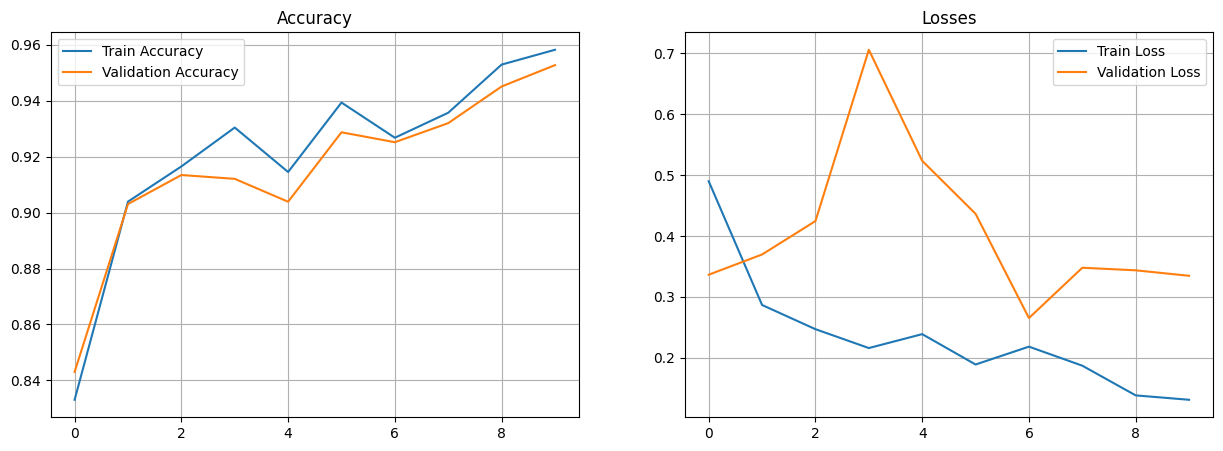

In [15]:
# Unfreezed backbone
weights = RegNet_X_800MF_Weights.DEFAULT
regnetx_unfreeze = regnet_x_800mf(weights=weights)
regnetx_unfreeze = modify_clsf_head(regnetx_unfreeze)
regnetx_unfreeze.to(device)
regnetx_unfreeze, unfreeze_metrics = train_model(regnetx_unfreeze, train_loader, val_loader, epochs=10, device=device)
plot_training_results(unfreeze_metrics['train_accs'],
                    unfreeze_metrics['train_losses'],
                    unfreeze_metrics['val_accs'],
                    unfreeze_metrics['val_losses'])

  0%|          | 0/11 [00:00<?, ?it/s]

Accuracy 0.8883792048929664


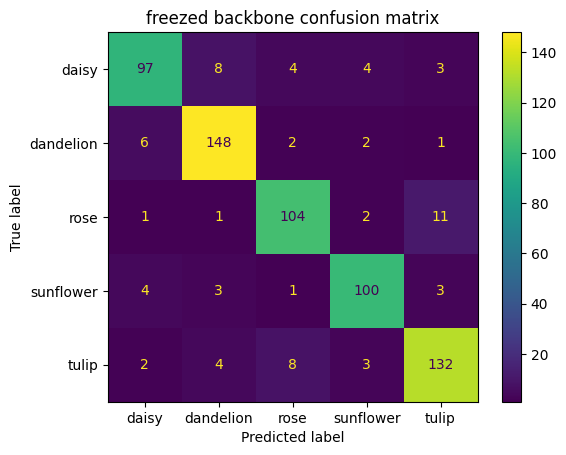

In [19]:
get_test_metrics(regnetx_freeze, "freezed backbone", test_loader, device=device)

  0%|          | 0/11 [00:00<?, ?it/s]

Accuracy 0.908256880733945


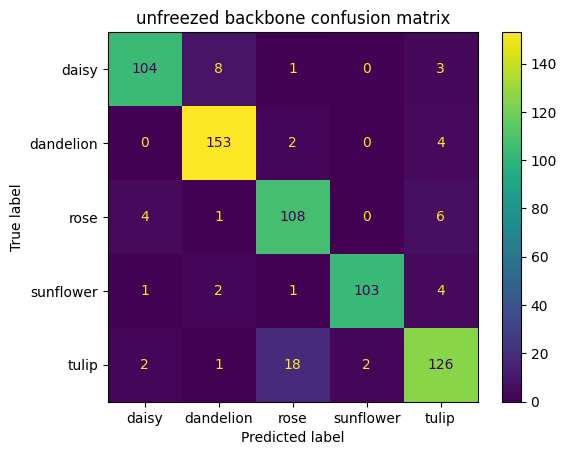

In [20]:
get_test_metrics(regnetx_unfreeze, "unfreezed backbone", test_loader, device=device)

In [21]:
model_save_path = './weights/backbone.pth'
regnetx_unfreeze.fc[-1] = nn.Identity()
torch.save(regnetx_unfreeze.state_dict(), model_save_path)

# 3. Similarity Search

In [60]:
_ = regnetx_unfreeze.eval()

In [143]:
import sqlitedict
filenames = [f"{idx_to_class[test_ds[i][1]]}/{os.path.basename(s[0])}" for i, s in enumerate(test_ds.samples)]
embeddings = []
with torch.no_grad():
    for images, _ in tqdm(test_loader):
        images = images.to(device)
        embeddings.extend(regnetx_unfreeze(images).cpu().detach().numpy())

embeddings = np.stack(embeddings)

with sqlitedict.SqliteDict('./db_dump.sqlite', autocommit=True) as db:
    for filename, embedding in zip(filenames, embeddings):
        db[filename] = embedding.tolist()

  0%|          | 0/11 [00:00<?, ?it/s]

In [116]:
from train import get_top5_similarity

most_similar = {}
for i in np.random.choice(np.arange(len(test_ds)), size=5):
    emb = regnetx_unfreeze(test_ds[i][0].unsqueeze(0).to(device))
    emb = emb.cpu().detach().numpy()
    most_similar[i] = get_top5_similarity(emb, embeddings)
most_similar

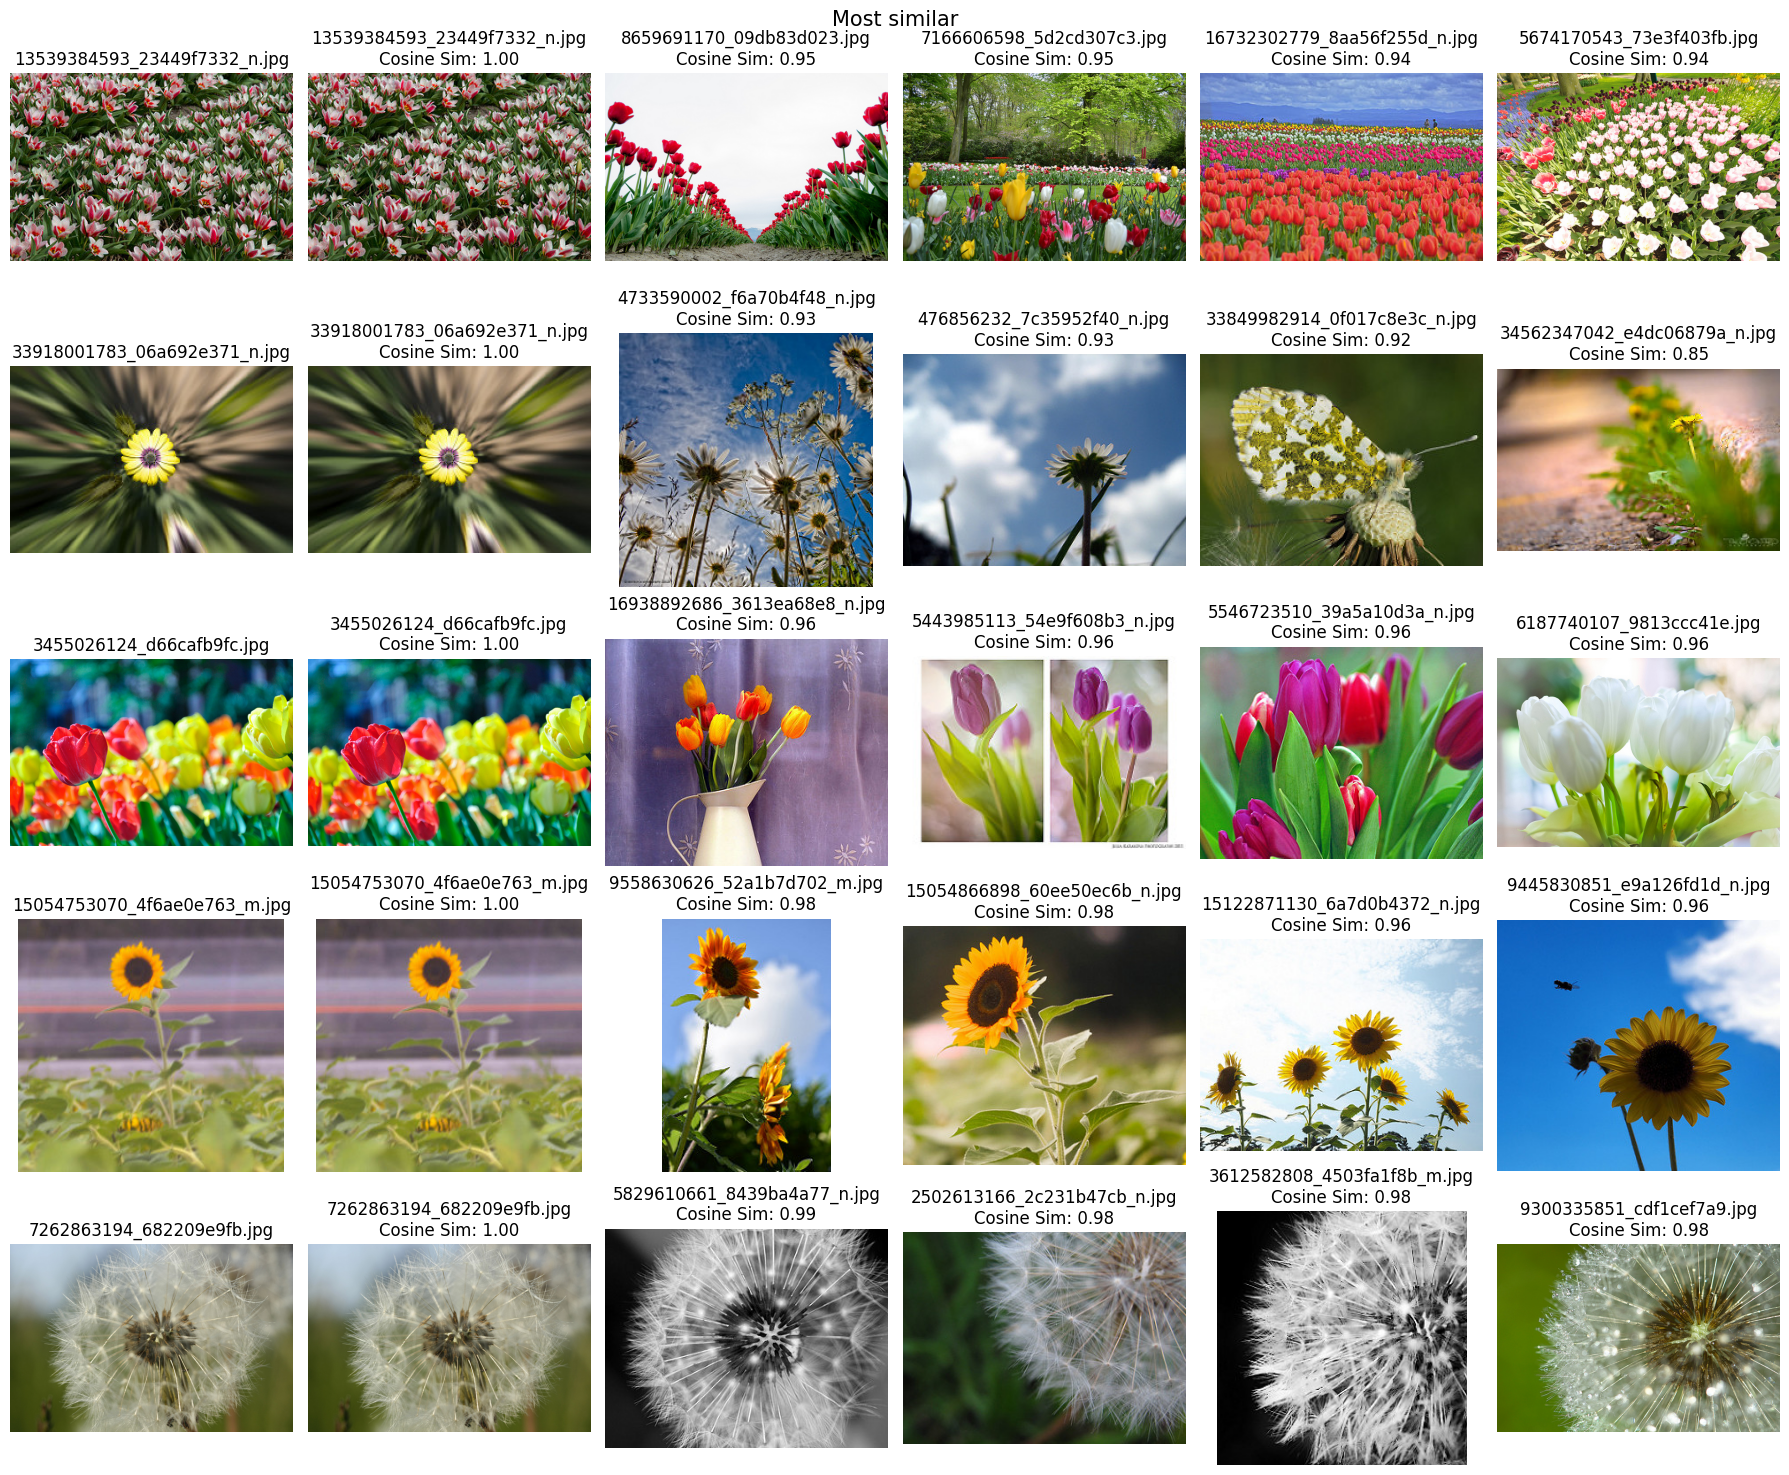

In [134]:
num_images = len(most_similar)
fig, axs = plt.subplots(num_images, 6, figsize=(18, num_images * 3))  # 6 columns: 1 for original and 5 for similar

test_ds.transform = None
for row, (index, similar_indices) in enumerate(most_similar.items()):
    # Display original image
    axs[row, 0].imshow(test_ds[index][0])  # Convert to HWC for display
    axs[row, 0].axis('off')
    axs[row, 0].set_title(f'{filenames[index]}')

    # Display similar images
    for col, (sim_index, similarity) in enumerate(similar_indices.items()):
        axs[row, col + 1].imshow(test_ds[sim_index][0])  # HWC format
        axs[row, col + 1].axis('off')
        axs[row, col + 1].set_title(f'{filenames[sim_index]}\nCosine Sim: {similarity:.2f}')

test_ds.transform = regnetx_transforms
# Adjust layout for better spacing
fig.suptitle("Most similar", fontsize=15)
plt.tight_layout()
plt.show()